In [117]:
import glob
import hashlib
import requests
import ConfigParser
from TwitterAPI import TwitterAPI
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import collections
import time
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import tarfile
from urllib import urlretrieve
import pickle
%matplotlib inline


In [118]:
def read_handles():
    """ Read a list of twitter handles and their type
    Args:
      filename: The name of the text file containing in format:
         <twitter handle> <M or C or L or R>M for manufacturer , c for corporate tech , L for reserach labs
    Returns:
      A list of (string, string) tuples representing each (handle, type) pair.
    """
    content= []
    with open("candidates.txt") as fileobject:
        content = tuple(line.split() for line in fileobject.readlines())
    return content 

read_handles()

(['FAANews', 'R'],
 ['AirbusGroup', 'M'],
 ['Boeing', 'M'],
 ['GulfstreamAero', 'M'],
 ['LockheedMartin', 'M'],
 ['BoeingAirplanes', 'M'],
 ['icao', 'R'],
 ['EASA', 'R'],
 ['Bombardier', 'M'],
 ['thalesgroup', 'C'],
 ['GEAviation', 'C'],
 ['Honeywell_Aero', 'C'],
 ['UTC', 'C'],
 ['RockwellCollins', 'C'],
 ['finmeccanicaweb', 'C'],
 ['Raytheon', 'M'],
 ['BAESystemsAir', 'M'])

##Classification Criteria is chosen based on the latest Market Trends, 

Reference: https://www.asme.org/engineering-topics/articles/aerospace-defense/top-5-aerospace-trends-now-future , ASME is the American Society of Mechanical Engineers.





In [119]:
def get_files(path):
    """ Returns a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    
    text_files=[]
    
    dir_files = [os.path.join(path,f) for f in os.listdir(path)]
    print dir_files
    for t in dir_files:
            for filename in os.listdir(t):
                text_files.append(os.path.join(t+os.sep+filename))
                 
    return text_files


all_train_files =  get_files("train\\")
print "Total label data",len(all_train_files)

['train\\accident_safety', 'train\\carrers', 'train\\cost', 'train\\Defence', 'train\\drones', 'train\\marketing', 'train\\Others', 'train\\space', 'train\\System']
Total label data 918


In [120]:
def get_true_labels(file_names):
    """Returns a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
   
    senti=[]
    for files in file_names:
       
        if re.search('accident_safety',files):
           
            senti.extend([1])
        elif re.search('carrers',files):
            senti.extend([2])
        elif re.search('cost',files):
            senti.extend([3])
        elif re.search('Defence',files):
            senti.extend([4])
        elif re.search('drones',files):
            senti.extend([5])
        elif re.search('marketing',files):
            senti.extend([6])
        elif re.search('space',files):
            senti.extend([7])
        elif re.search('System',files):
            senti.extend([8])
        else:
            senti.extend([9])
    return np.array(senti)
        

labels = get_true_labels(all_train_files)
print labels[[[1,2,3,-3,-2,-1]]]


[1 1 1 8 8 8]


In [121]:
def show_distribution(dist_data,label):
    """Calls the Plot Bar Graph function for class in the data along with the respective labels
    """
    for i in range(0,len(dist_data)):
        plot_bar_graph(collections.Counter(dist_data[i]),label[i])

In [122]:
def plot_bar_graph(counter,label):
    """Plots the Bar Graph from the contens of the counter variable
    Params:
    1. counter : Number of tweets for every companies
    2. label   : list of labels. 
    """
    fig = plt.figure()
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    values = [counter[k] for k in keys]
    
    plt.barh(y_pos, values, align='center', alpha=0.9)
    plt.yticks(y_pos, keys)
    plt.xlabel('Number of tweets')
    plt.title(label)

    plt.show()
    fig.savefig(label+'.png')

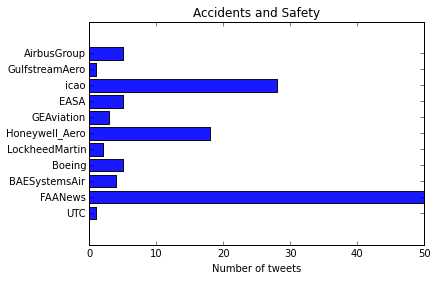

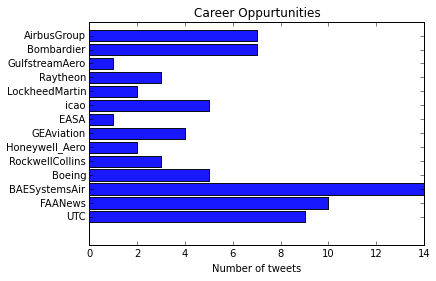

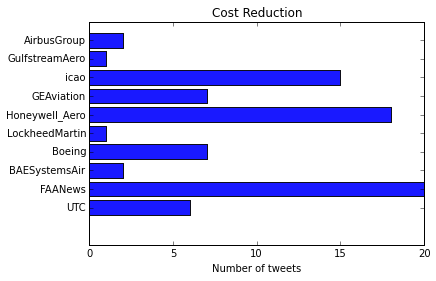

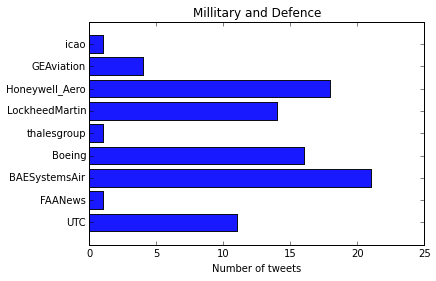

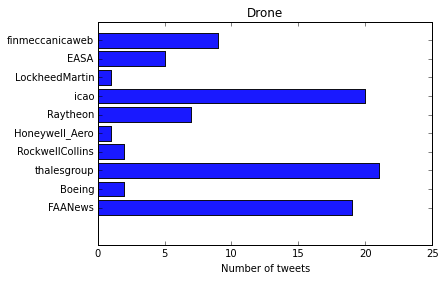

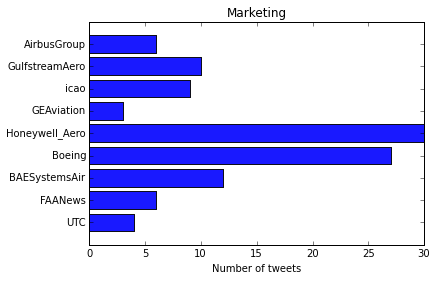

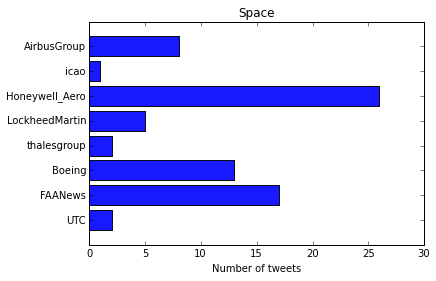

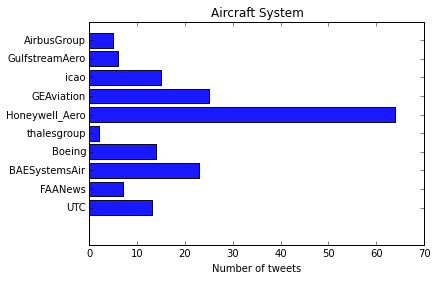

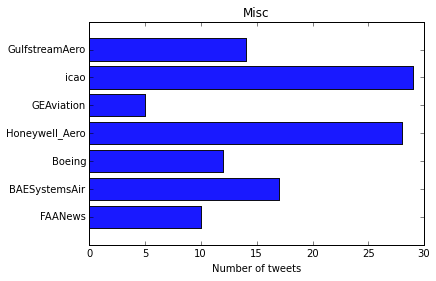

In [123]:
from collections import Counter
def who_isdoing_what(filelist,labels):
    """From the file list evaluate the distribution of labels
        Under the class 1--> Safety , Tweets belong to, boeing is 12,Airbus is 14, FAA is 20
        params:
        1.Filelist: filenames of all tweets
        2.Labels  : lables under which the files are classified. 
        Returns the distribution of tweets for every company. 
        """
    c=[]
    file_list={}
    data=[]
    for itr in range(0,len(set(labels))):
        data.append([])
    j=0
    
    for i in range(0,len(labels)):
        m = re.search(".\\\([\w]+).txt",filelist[i])
        c.append(m.group(1))
    for lines in open("list_full.txt").readlines():
        line =lines.split('\\')
        file_list[line[2].replace('\n','')]=line[1]
   
    for i in range(0,len(c)):
        #print c[i]
        if(c[i] in file_list.keys()):
            data[int(labels[i])-1].append(file_list[c[i]]) 
            
       

    return data

dist_data = who_isdoing_what(all_train_files,labels)
label =['Accidents and Safety','Career Oppurtunities','Cost Reduction','Millitary and Defence','Drone','Marketing','Space','Aircraft System','Misc']
show_distribution(dist_data,label)

## Classification of new tweets 

1. Tokenizer
2. Feature Vector Matrix
3. Classifier function : Logistic Regression
4. Cross Validation of the labeled data
5. Top Terms of Each Class

In [124]:
def tokenize_with_punct_nourl(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.The URL that starts with http(s)will be removed
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    text = re.sub('http*\S+', '', text)
    l =re.split("(\W)+?",text.lower()) 
    return [r for r in l if r.strip() and r!='rt'] 

tokenize_with_punct_nourl("#Boeing team hits the road to test new technologies on unmanned aerial vehicles: http://t.co/18woDCVyGY http://t.co/oqiqOW4Dmb")

['#',
 'boeing',
 'team',
 'hits',
 'the',
 'road',
 'to',
 'test',
 'new',
 'technologies',
 'on',
 'unmanned',
 'aerial',
 'vehicles',
 ':']

In [125]:
def do_vectorize(filenames, tokenizer_fn=tokenize_with_punct_nourl, min_df=2,
                 max_df=1., binary=False, ngram_range=(1,1)):
    """
    Converts a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
   
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
  
    if (isinstance(filenames,list)==False):
        filenames = filenames.tolist()
    
    vectorizer = CountVectorizer(input="filename",tokenizer=tokenizer_fn,min_df=min_df,max_df=max_df,binary=binary,ngram_range=ngram_range,dtype=int)
    X = vectorizer.fit_transform(eachfile for eachfile in filenames)
    return (X,vectorizer)
    
matrix, vec = do_vectorize(all_train_files,tokenizer_fn=tokenize_with_punct_nourl)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % ((sorted(matrix[0].nonzero()[1]))))

matrix represents 918 documents with 1597 features
first doc has terms:
[93, 99, 107, 174, 219, 615, 663, 746, 762, 1375, 1416, 1432]


In [126]:
matrix[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 746,  174, 1416, 1432,   99,  663, 1375,  615,  219,  107,  762,
          93]))

In [127]:
def repeatable_random(seed):
    """Randomize tweets to in the files in which the tweets are stored. 
    """
    hash = unicode(seed)
    print 
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))



first shuffled document train\accident_safety\6784092288843777.txt has label 1 and terms: [95, 96, 192, 1584]


In [128]:
#Logistic Regression fucntion
def get_clf(c=1, penalty='l2'):
    
    return LogisticRegression(random_state=42, C=c, penalty=penalty)

In [129]:
def do_cross_validation(X, y, n_folds=10, c=1, penalty='l2',verbose=False):
    """
    Performs n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
        c.........Classifier Co-efficient
        penalty...Type of regularization.
    Return:
        the average testing accuracy across all folds.
    """
    
    cv = KFold(len(y), n_folds=n_folds, shuffle=False)
    accuracies = []
    train_accuracies = []
    for foldi, (train, test) in enumerate(cv):
        clf = get_clf(c=c, penalty=penalty)
        clf.fit(X[train], y[train])
        train_accuracies.append(accuracy_score(clf.predict(X[train]), y[train]))
        pred = clf.predict(X[test])
        acc = accuracy_score(pred, y[test])
        accuracies.append(acc)
        if verbose:
            print('fold %d accuracy=%.4g' % (foldi, acc))
    return np.mean(accuracies), np.mean(train_accuracies)
    

print('average cross validation accuracy=%.4f  Training accuracy %.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.5435
fold 1 accuracy=0.4891
fold 2 accuracy=0.5217
fold 3 accuracy=0.6413
fold 4 accuracy=0.5326
fold 5 accuracy=0.587
fold 6 accuracy=0.5543
fold 7 accuracy=0.6087
fold 8 accuracy=0.6374
fold 9 accuracy=0.5934
average cross validation accuracy=0.5709  Training accuracy 0.9665


In [130]:
def do_expt(filenames, y, tokenizer_fn=tokenize_with_punct_nourl,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=10):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    
   
    matrix1, vec11 = do_vectorize(filenames, tokenizer_fn=tokenizer_fn, min_df=min_df,max_df=max_df, binary=binary, ngram_range=ngram_range)
    
    return do_cross_validation(matrix1, y, n_folds=n_folds)

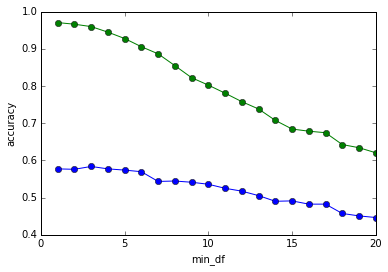

[(0.57742474916387965, 0.97070964511888425),
 (0.57633779264214036, 0.96635231634514318),
 (0.58399426660296228, 0.95993702258227898),
 (0.5774605828953655, 0.94504964119560475),
 (0.57419971333014808, 0.92786245685124624),
 (0.56983994266602944, 0.90583485336011316),
 (0.54370520783564269, 0.88671106218397833),
 (0.5448160535117057, 0.8550001317519198),
 (0.54153129479216433, 0.82256310185008963),
 (0.53610845676063068, 0.80259170665581436),
 (0.52525083612040135, 0.78092656733547849),
 (0.51759436215957955, 0.75817066850924164),
 (0.50557811753463933, 0.73844228241170429),
 (0.49036072623029137, 0.70782079396634756),
 (0.49141184902054463, 0.68458195115809928),
 (0.48266841853798381, 0.67877242344481492),
 (0.48265647396082179, 0.67465707903065719),
 (0.45759675107501196, 0.64282537600534029),
 (0.45105112279025328, 0.63435197086233086),
 (0.44671524128045875, 0.62079455191172039)]

In [131]:
def min_df_expt(filenames, y):
    """
    Various settings of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    data =[do_expt(filenames, y,tokenizer_fn=tokenize_with_punct_nourl,min_df=f) for f in range(1,21)]
    plt.plot(range(1,21),data,marker='o')
    plt.xlabel("min_df")
    plt.ylabel("accuracy")
    plt.show()
    return data

min_df_expt(filenames, y)

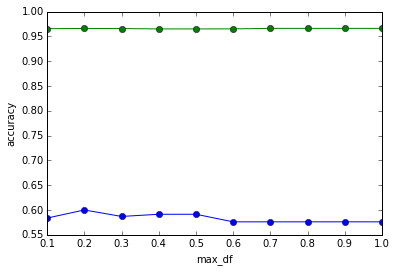

[(0.58393454371715248, 0.96574698946862991),
 (0.60027472527472514, 0.96623110457881833),
 (0.58719541328236979, 0.96598897382821303),
 (0.59159101767797417, 0.96526302074946346),
 (0.59159101767797417, 0.96526302074946346),
 (0.57631390348781653, 0.9653842325157882),
 (0.57633779264214036, 0.96635231634514318),
 (0.57633779264214036, 0.96635231634514318),
 (0.57633779264214036, 0.96635231634514318),
 (0.57633779264214036, 0.96635231634514318)]

In [132]:
def max_df_expt(filenames, y):
    """
    Various settings of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    max_df_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    data = [ do_expt(filenames, y,tokenizer_fn=tokenize_with_punct_nourl,max_df=f,min_df=2) for f in max_df_list ]
    plt.plot(max_df_list,data,marker='o')
    plt.xlabel("max_df")
    plt.ylabel("accuracy")
    plt.show()
    return data
    
max_df_expt(filenames, y)

In [133]:
#First, we'll train our final classifier using our best settings.
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize_with_punct_nourl,
                      binary=True, min_df=2, max_df=.6)    
acc = do_expt(filenames, y, tokenizer_fn=tokenize_with_punct_nourl,
                      binary=True, min_df=2, max_df=.6)
clf = get_clf()
clf.fit(X, y)
print "Final CV Accuracy with best settings",acc[0]


Final CV Accuracy with best settings 0.576313903488


In [134]:
def top_features_of_a_class(vec,cl):
    """Retruns the top feature vectors for a particular class
    Params:
    Vec.....Feature vectors
    Cl......Class number
    """
    feature_names = vec.get_feature_names()
    top_pos = sorted(sorted(zip(clf.coef_[cl], feature_names))[-20:],reverse=True)
    print top_pos

top_features_of_a_class(vec,6)

[(2.7861009446530987, u'nasa_orion'), (2.7534121510505858, u'space'), (1.6570725878454038, u'orion'), (1.6386723246392136, u'nasa'), (1.0861565389089414, u'science'), (0.88565894739755624, u'protospace'), (0.84865417196581394, u'it'), (0.83992317123802074, u'journeytomars'), (0.81456364023344097, u'look'), (0.80452866614103979, u'satellite'), (0.77875344261576929, u'dfw'), (0.7399979667799429, u'commercial'), (0.66621850388086912, u'esa'), (0.63600244373444204, u'no'), (0.61805998801625306, u'spacecraft'), (0.61391997659040498, u'technology'), (0.59686271710136873, u'w'), (0.59157587020943281, u'sky'), (0.57555135422425663, u'factfriday'), (0.57293632469641753, u'faaast')]


### Testing the Classifier with new Test Data

There are 17 chosen Twitter Handles  and the training was done using 918 documents, So an even split of 54 latest tweets from 17 handles are chosen. 

Data Cleaning : Test Data was checked to see if the tweets are in English only, Other than that contents of the test data is unknown.

In [135]:
all_test_files = get_files("test_m2\\")
print len(all_test_files)
X_test = vec.transform(all_test_files)

['test_m2\\AirbusGroup', 'test_m2\\BAESystemsAir', 'test_m2\\Boeing', 'test_m2\\BoeingAirplanes', 'test_m2\\Bombardier', 'test_m2\\EASA', 'test_m2\\FAANews', 'test_m2\\finmeccanicaweb', 'test_m2\\GEAviation', 'test_m2\\GulfstreamAero', 'test_m2\\Honeywell_Aero', 'test_m2\\icao', 'test_m2\\LockheedMartin', 'test_m2\\Raytheon', 'test_m2\\RockwellCollins', 'test_m2\\thalesgroup', 'test_m2\\UTC']
918


##Predicting the Class for the Test Data using Logistic Regression and the compute the accuracy

In [136]:
"""
Finding the accuracy of labels predicts using Logistic Regression ,
In order to calculate the accuracy a sample of 100 Test Data is labelled manually vs the predicted data
"""

newy=clf.predict(X_test)
manualy_y = [2,2,1,6,8,1,1,2,8,8,9,8,2,2,8,1,3,8,7,9,8,6,3,8,3,3,9,9,2,2,3,2,8,2,7,3,9,2,3,2,8, 1, 8, 8, 3, 6,
       8, 8, 9, 8, 9, 7, 2, 8, 2, 3, 2, 9, 6, 8, 8, 8, 7, 8, 8, 8, 4, 9, 8,
       3, 9, 9, 9, 6, 6, 8, 8, 6, 8, 6, 4, 8, 1, 8, 9, 8, 2, 8, 6, 6, 6, 6,
       1, 8, 4, 6, 6, 2, 6, 9]
print "Accuracy for 100 labeled Test Data using Logistic Regression is : ",accuracy_score(manualy_y,newy[:100])


Accuracy for 100 labeled Test Data using Logistic Regression is :  0.61



##Predicting the Class for the Test Data using Multinominal Naive Bayes and the compute the accuracy

In [137]:

def Multinomial_NB(files,y):
    """
    Finding the accuracy of labels predicts using Multinominal Naivee Bayes ,
    In order to calculate the accuracy a sample of 100 Test Data is labelled manually vs the predicted data
    """
    all_files = get_files(files)
    X_navie = vec.transform(all_files)
    model = MultinomialNB()
    model.fit(X.toarray(),y)
    naviey = model.predict(X_navie.toarray())
    return naviey

latest_naive_y = Multinomial_NB("test_m2\\",y)
print "Accuracy for 100 labeled Test Data using Multinominal Naivee Bayes is : ",accuracy_score(manualy_y,latest_naive_y[:100])

['test_m2\\AirbusGroup', 'test_m2\\BAESystemsAir', 'test_m2\\Boeing', 'test_m2\\BoeingAirplanes', 'test_m2\\Bombardier', 'test_m2\\EASA', 'test_m2\\FAANews', 'test_m2\\finmeccanicaweb', 'test_m2\\GEAviation', 'test_m2\\GulfstreamAero', 'test_m2\\Honeywell_Aero', 'test_m2\\icao', 'test_m2\\LockheedMartin', 'test_m2\\Raytheon', 'test_m2\\RockwellCollins', 'test_m2\\thalesgroup', 'test_m2\\UTC']
Accuracy for 100 labeled Test Data using Multinominal Naivee Bayes is :  0.71


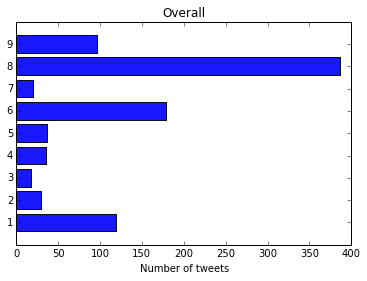

In [138]:
"""Ploting the distribution of top 918 Tweets (i.e 54 tweets from 17 handles) 
If the same is done for tweets with regular intervals like monthly/quarterly/Half Yearly we can get the trend growth graph. 
"""
pt_data = collections.Counter(latest_naive_y)
plot_bar_graph(pt_data,'Overall')

##Legend

Class 1 : Accidents and Safety

Class 2 : Carrers

Class 3 : Cost/Money

Class 4 : Millitary and Defense

Class 5 : Drones

Class 6 : Marketing

Class 7 : Space

Class 8 : Aircraft Hardware Systems

Class 9 : Others

#Ploting the distribution of tweets classified under different categories 



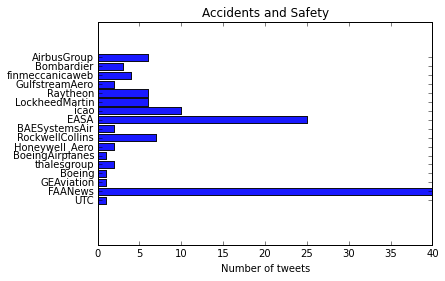

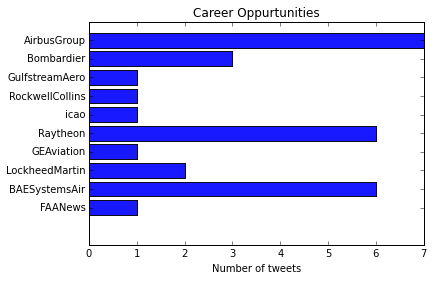

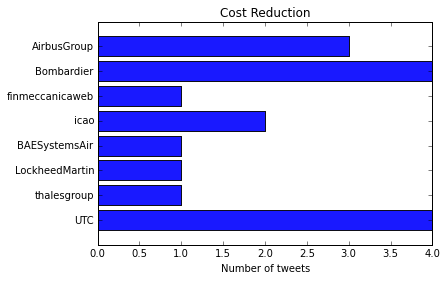

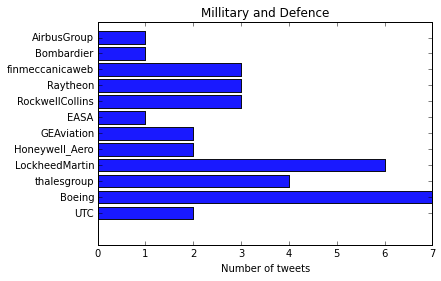

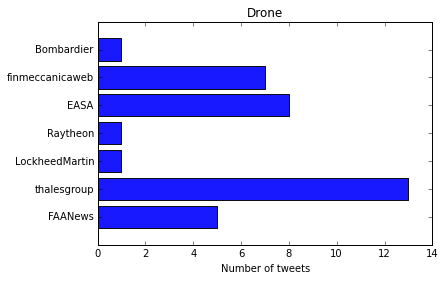

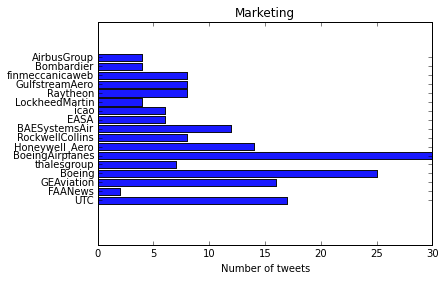

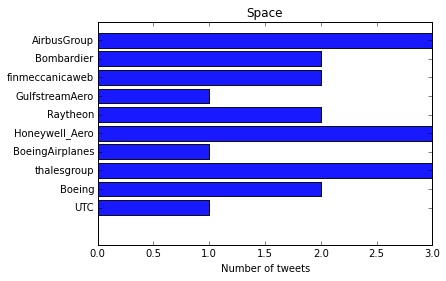

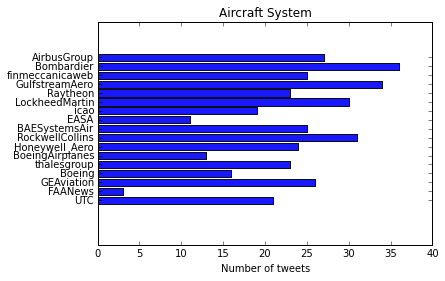

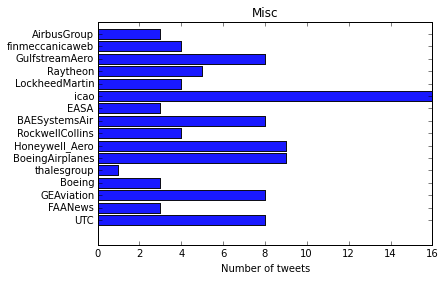

In [139]:
dist_data = who_isdoing_what(all_test_files,naviey)
label =['Accidents and Safety','Career Oppurtunities','Cost Reduction','Millitary and Defence','Drone','Marketing','Space','Aircraft System','Misc']
show_distribution(dist_data,label)

#Claims to support the results

## Graph 1 : Accidents and Safety 

Classifier has predicted more tweets from FAA (Federal Avionics Agency: https://www.faa.gov/) and EASA (European Avionics Safety Agency : https://www.faa.gov/ ). FAA and EASA are the top safety regulators in the Aviation Industry. 

## Graph 2 : Careers 

From the Career website of Airbus we can see that more than 187 job openings were posted in last few months and the same was posted in social media 
Airbus Career: http://www.airbusgroup.com/int/en/people-careers/jobs-and-applications/search-for-vacancies.html?queryStr=&country=gb&country=us

##Graph 3: Cost and Money Related

The second most prominent in this regard in Bombardier ,  we can see from the companies press release than , recently they have released their "Strategic and Transformation Objectives through 2020" and acquisition of a smaller company. So the tweets were classified under the Cost/Money category. 

Press Release : http://ir.bombardier.com/en/press-releases/press-releases 

##Graph 4: Military and Defence

The top 2 military aircraft manufactures in US are Lockheed Martin and Boeing , The same has been reflected in the classification of tweets. 

List of Manufactures: http://web.stanford.edu/class/e297a/U.S.%20Defense%20Industry%20and%20Arms%20Sales.htm

##Graph 7: Aircraft Systems

From the graph we can see that two regulators FAA and EASA (Non manufactures) have the least amount of graphs classified under them and all top Aircraft System manufactures have higher tweets under their name. 



##Trend Graph for two set of tweets set2 latest 918 tweets and set 1 - immediate past 918 tweets.

In [140]:
##Classifying the old tweets, in order to draw the trend graph 
first_month_y = Multinomial_NB("test_m1",y)

['test_m1\\AirbusGroup', 'test_m1\\BAESystemsAir', 'test_m1\\Boeing', 'test_m1\\BoeingAirplanes', 'test_m1\\Bombardier', 'test_m1\\EASA', 'test_m1\\FAANews', 'test_m1\\finmeccanicaweb', 'test_m1\\GEAviation', 'test_m1\\GulfstreamAero', 'test_m1\\Honeywell_Aero', 'test_m1\\icao', 'test_m1\\LockheedMartin', 'test_m1\\Raytheon', 'test_m1\\RockwellCollins', 'test_m1\\thalesgroup', 'test_m1\\UTC']


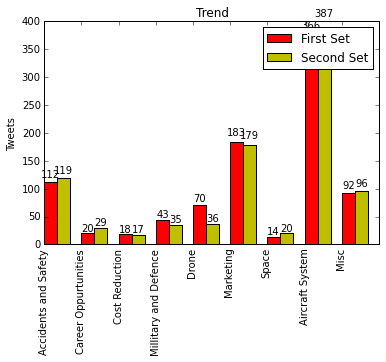

In [141]:
#graph between the latest tweet and older tweets
draw_trend_graph(collections.Counter(first_month_y),collections.Counter(latest_naive_y),label)


In [142]:
def draw_trend_graph(m1,m2,label):
    """ Draw 2 bar graph with different sets of values n1/m2
    Params:
    m1......Values for First set
    m2......Values for Second set.
    label... List of X axis 
    """
    N=9
    fig = plt.figure()

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig1, ax = plt.subplots()
    keys1 = m1.keys()
    keys2 = m2.keys()

    # get the counts for each key, assuming the values are numerical
    values1= [m1[k] for k in keys1]
    values2= [m2[k] for k in keys2]
    rects1 = ax.bar(ind, values1, width, color='r')
    rects2 = ax.bar(ind + width, values2, width, color='y')
    ax.set_ylabel('Tweets')
    ax.set_title('Trend')
    ax.legend((rects1[0], rects2[0]), ('First Set', 'Second Set'))
    ax.set_xticklabels(label)

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
    fig1.savefig("Trend.png")

    plt.show()